In [1]:
# !pip install --upgrade pip

In [2]:
# !pip install torch
# !pip install tqdm
# !pip install torchvision
# !pip install torchsummary

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import sys
sys.path.append('../')
from tqdm import tqdm 
import torch.nn as nn
import random, math
import numpy as np
import matplotlib.pyplot as plt # for plotting beautiful graphs

In [4]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU6(inplace=True),
        )
        self.left2 = nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(outchannel)
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = self.left2(out)
        out = F.relu6(out)
        out = self.left2(out)
        out = self.bn(out)
        out += self.shortcut(x)
        out = F.relu6(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock,model_type = 'fx', num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.model_type = model_type
        if(self.model_type == 'fx'):
            self.layer5 = self.make_layer(ResidualBlock, 512, 2, stride=2)
            self.layer6 = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
        elif(self.model_type == 'ffx'):
            self.layer5 = self.make_layer(ResidualBlock, 512, 2, stride=2)
            self.fc = nn.Linear(512, num_classes)
        elif(self.model_type == 'fgx'):
            self.layer5 = self.make_layer(ResidualBlock, 512, 2, stride=2)
            self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride=2)
            self.fc = nn.Linear(512, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out) # 512, 2, 2

        if(self.model_type == 'ffx'):
            out = self.layer5(out) # 512, 1, 1
        else:
            out = self.layer6(out)

        if(self.model_type == 'fx'):
            out = F.avg_pool2d(out, 2)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
        elif(self.model_type == 'ffx' or self.model_type == 'fgx'):
            out = F.avg_pool2d(out, 1)
            out = out.view(out.size(0), -1)
            out = self.fc(out)          
        return out


def ResNet18(model_type):

    return ResNet(ResidualBlock,model_type = model_type)

In [6]:
fx = ResNet18(model_type = 'fx')
ffx = ResNet18(model_type = 'ffx')
fgx = ResNet18(model_type = 'fgx')
a = torch.rand(4, 3, 32, 32)
out = fx(a)
out = ffx(a)
out = fgx(a)

In [7]:
def calculate_accuracy(outputs, labels):
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    return correct

In [8]:
lrs = []
def train(epoch, model,trainloader,optimizer, lr_scheduler):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    # training
    for e in range(1):  # loop over the dataset multiple times
        correct_answer = 0
        running_loss = 0.0
        for i, data in tqdm(enumerate(trainloader, 0), total = len(trainloader), desc = 'training'):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.to('cpu')
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            
            correct_answer += calculate_accuracy(outputs, labels)
            # print statistics
            running_loss += loss.item()

    print( 'Epoch', str(epoch), 'accuracy :', 100*correct_answer/(len(trainloader)*16) )
    print( 'Epoch', str(epoch), 'loss :', running_loss / (len(trainloader)))


    return optimizer.param_groups[0]['lr']



In [9]:
def validation(model,testloader):

    classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model = model.to(device)
    with torch.no_grad():
        for data in tqdm(testloader, total = len(testloader),desc = 'validation'):
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            outputs = outputs.to('cpu')
            _, predicted = torch.max(outputs, 1)
            
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    correct = 0
    total = 0
    for i in range(10):
        correct += class_correct[i]
        total += class_total[i]
    print('valid accuracy :', correct/ total)
        



In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    accuracy = (correct / total)
#     accuracies.append(accuracy)
    
    return accuracy

In [12]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), #R,G,B每层的归一化用到的均值和方差
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


# FashionMNIST
# trainSet = datasets.KMNIST(root='KMNIST', download=True, train=True, transform=train_transform)
# testSet = datasets.KMNIST(root='KMNIST', download=True, train=False, transform=valid_transform)
# train_loader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
EPOCH = 50
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [14]:
use_cuda = torch.cuda.is_available()
model = ResNet18(model_type = 'fx')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20,25,30,35])

valid_loss_min = np.Inf # track change in validation loss
pat = 3
n_epochs = EPOCH
fx_train_losses, fx_valid_losses, fx_accuracies = [], [], []

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
#         train_losses.append(train_loss/len(train_loader.dataset))


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
#         valid_losses.append(valid_loss/len(test_loader.dataset))

    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    fx_train_losses.append(train_loss)
    fx_valid_losses.append(valid_loss)

        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'fx_model_CNN.pth')
        valid_loss_min = valid_loss
        
    fx_accuracy = test(test_loader, model, criterion, use_cuda)
    fx_accuracies.append(fx_accuracy)

  0%|          | 0/391 [00:00<?, ?it/s]

running epoch: 1


100%|██████████| 79/79 [00:03<00:00, 22.35it/s]


	Training Loss: 1.568800 	Validation Loss: 1.268452
Validation loss decreased (inf --> 1.268452).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.266630
Test Accuracy: 53% (5388/10000)
running epoch: 2


100%|██████████| 79/79 [00:03<00:00, 22.21it/s]

	Training Loss: 1.128435 	Validation Loss: 1.429073



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.428917
Test Accuracy: 54% (5462/10000)
running epoch: 3


100%|██████████| 79/79 [00:03<00:00, 21.14it/s]


	Training Loss: 0.912055 	Validation Loss: 0.857040
Validation loss decreased (1.268452 --> 0.857040).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.855358
Test Accuracy: 70% (7082/10000)
running epoch: 4


100%|██████████| 79/79 [00:03<00:00, 20.64it/s]


	Training Loss: 0.770500 	Validation Loss: 0.746520
Validation loss decreased (0.857040 --> 0.746520).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.747785
Test Accuracy: 74% (7456/10000)
running epoch: 5


100%|██████████| 79/79 [00:03<00:00, 22.25it/s]

	Training Loss: 0.654129 	Validation Loss: 0.767384



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.767962
Test Accuracy: 73% (7373/10000)
running epoch: 6


100%|██████████| 79/79 [00:03<00:00, 20.96it/s]


	Training Loss: 0.586240 	Validation Loss: 0.681744
Validation loss decreased (0.746520 --> 0.681744).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.680026
Test Accuracy: 77% (7780/10000)
running epoch: 7


100%|██████████| 79/79 [00:03<00:00, 20.18it/s]


	Training Loss: 0.523911 	Validation Loss: 0.633366
Validation loss decreased (0.681744 --> 0.633366).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.636422
Test Accuracy: 79% (7962/10000)
running epoch: 8


100%|██████████| 79/79 [00:03<00:00, 21.62it/s]


	Training Loss: 0.470318 	Validation Loss: 0.575997
Validation loss decreased (0.633366 --> 0.575997).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.575966
Test Accuracy: 81% (8117/10000)
running epoch: 9


100%|██████████| 79/79 [00:03<00:00, 20.20it/s]

	Training Loss: 0.424680 	Validation Loss: 0.673531



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.670101
Test Accuracy: 78% (7875/10000)
running epoch: 10


100%|██████████| 79/79 [00:03<00:00, 21.18it/s]


	Training Loss: 0.396567 	Validation Loss: 0.519776
Validation loss decreased (0.575997 --> 0.519776).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.517634
Test Accuracy: 82% (8296/10000)
running epoch: 11


100%|██████████| 79/79 [00:03<00:00, 20.38it/s]


	Training Loss: 0.369789 	Validation Loss: 0.444189
Validation loss decreased (0.519776 --> 0.444189).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.446373
Test Accuracy: 85% (8582/10000)
running epoch: 12


100%|██████████| 79/79 [00:03<00:00, 21.56it/s]

	Training Loss: 0.340115 	Validation Loss: 0.468752



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.465002
Test Accuracy: 85% (8506/10000)
running epoch: 13


100%|██████████| 79/79 [00:03<00:00, 20.79it/s]

	Training Loss: 0.321110 	Validation Loss: 0.510152



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.507371
Test Accuracy: 84% (8441/10000)
running epoch: 14


100%|██████████| 79/79 [00:04<00:00, 19.55it/s]


	Training Loss: 0.303385 	Validation Loss: 0.385876
Validation loss decreased (0.444189 --> 0.385876).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.384842
Test Accuracy: 87% (8761/10000)
running epoch: 15


100%|██████████| 79/79 [00:04<00:00, 18.27it/s]

	Training Loss: 0.279756 	Validation Loss: 0.396429



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.394653
Test Accuracy: 87% (8768/10000)
running epoch: 16


100%|██████████| 79/79 [00:03<00:00, 22.18it/s]


	Training Loss: 0.263862 	Validation Loss: 0.378072
Validation loss decreased (0.385876 --> 0.378072).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.379250
Test Accuracy: 88% (8822/10000)
running epoch: 17


100%|██████████| 79/79 [00:03<00:00, 20.50it/s]

	Training Loss: 0.245017 	Validation Loss: 0.395830



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.394979
Test Accuracy: 87% (8766/10000)
running epoch: 18


100%|██████████| 79/79 [00:04<00:00, 16.89it/s]

	Training Loss: 0.233604 	Validation Loss: 0.407418



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.410661
Test Accuracy: 87% (8720/10000)
running epoch: 19


100%|██████████| 79/79 [00:03<00:00, 20.01it/s]


	Training Loss: 0.220133 	Validation Loss: 0.376894
Validation loss decreased (0.378072 --> 0.376894).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.379063
Test Accuracy: 88% (8816/10000)
running epoch: 20


100%|██████████| 79/79 [00:03<00:00, 20.33it/s]

	Training Loss: 0.213362 	Validation Loss: 0.416633



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.417844
Test Accuracy: 87% (8774/10000)
running epoch: 21


100%|██████████| 79/79 [00:04<00:00, 19.15it/s]


	Training Loss: 0.201517 	Validation Loss: 0.370636
Validation loss decreased (0.376894 --> 0.370636).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.370013
Test Accuracy: 88% (8893/10000)
running epoch: 22


100%|██████████| 79/79 [00:03<00:00, 22.29it/s]

	Training Loss: 0.185784 	Validation Loss: 0.391044



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.391276
Test Accuracy: 88% (8856/10000)
running epoch: 23


100%|██████████| 79/79 [00:03<00:00, 21.03it/s]


	Training Loss: 0.176616 	Validation Loss: 0.339154
Validation loss decreased (0.370636 --> 0.339154).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.338785
Test Accuracy: 89% (8976/10000)
running epoch: 24


100%|██████████| 79/79 [00:03<00:00, 21.90it/s]

	Training Loss: 0.166671 	Validation Loss: 0.340189



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.341676
Test Accuracy: 89% (8984/10000)
running epoch: 25


100%|██████████| 79/79 [00:03<00:00, 22.13it/s]

	Training Loss: 0.157117 	Validation Loss: 0.347041



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.347312
Test Accuracy: 90% (9007/10000)
running epoch: 26


100%|██████████| 79/79 [00:03<00:00, 20.84it/s]

	Training Loss: 0.152597 	Validation Loss: 0.405871



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.403048
Test Accuracy: 88% (8839/10000)
running epoch: 27


100%|██████████| 79/79 [00:03<00:00, 22.15it/s]

	Training Loss: 0.142135 	Validation Loss: 0.484877



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.485246
Test Accuracy: 87% (8707/10000)
running epoch: 28


100%|██████████| 79/79 [00:04<00:00, 19.04it/s]

	Training Loss: 0.136565 	Validation Loss: 0.395937



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.398970
Test Accuracy: 89% (8906/10000)
running epoch: 29


100%|██████████| 79/79 [00:03<00:00, 20.91it/s]

	Training Loss: 0.124589 	Validation Loss: 0.407118



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.411821
Test Accuracy: 88% (8873/10000)
running epoch: 30


100%|██████████| 79/79 [00:03<00:00, 20.33it/s]

	Training Loss: 0.119613 	Validation Loss: 0.388557



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.388528
Test Accuracy: 89% (8933/10000)
running epoch: 31


100%|██████████| 79/79 [00:03<00:00, 22.16it/s]

	Training Loss: 0.116862 	Validation Loss: 0.400065



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.399500
Test Accuracy: 89% (8922/10000)
running epoch: 32


100%|██████████| 79/79 [00:03<00:00, 20.98it/s]

	Training Loss: 0.109709 	Validation Loss: 0.407241



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.405909
Test Accuracy: 89% (8901/10000)
running epoch: 33


100%|██████████| 79/79 [00:03<00:00, 22.22it/s]

	Training Loss: 0.107425 	Validation Loss: 0.367130



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.368459
Test Accuracy: 90% (9018/10000)
running epoch: 34


100%|██████████| 79/79 [00:04<00:00, 19.27it/s]

	Training Loss: 0.102549 	Validation Loss: 0.371309



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.373427
Test Accuracy: 90% (9029/10000)
running epoch: 35


100%|██████████| 79/79 [00:03<00:00, 21.00it/s]

	Training Loss: 0.093996 	Validation Loss: 0.395536



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.396071
Test Accuracy: 89% (8973/10000)
running epoch: 36


100%|██████████| 79/79 [00:03<00:00, 21.91it/s]

	Training Loss: 0.091809 	Validation Loss: 0.377962



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.373846
Test Accuracy: 90% (9021/10000)
running epoch: 37


100%|██████████| 79/79 [00:03<00:00, 22.07it/s]

	Training Loss: 0.091911 	Validation Loss: 0.361425



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.358355
Test Accuracy: 90% (9031/10000)
running epoch: 38


100%|██████████| 79/79 [00:03<00:00, 20.43it/s]

	Training Loss: 0.085140 	Validation Loss: 0.421000



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.422584
Test Accuracy: 89% (8982/10000)
running epoch: 39


100%|██████████| 79/79 [00:03<00:00, 20.45it/s]

	Training Loss: 0.085150 	Validation Loss: 0.403980



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.409589
Test Accuracy: 89% (8967/10000)
running epoch: 40


100%|██████████| 79/79 [00:03<00:00, 20.11it/s]

	Training Loss: 0.077628 	Validation Loss: 0.374441



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.378822
Test Accuracy: 90% (9073/10000)
running epoch: 41


100%|██████████| 79/79 [00:03<00:00, 21.99it/s]


	Training Loss: 0.079583 	Validation Loss: 0.337862
Validation loss decreased (0.339154 --> 0.337862).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.339611
Test Accuracy: 91% (9121/10000)
running epoch: 42


100%|██████████| 79/79 [00:03<00:00, 21.83it/s]

	Training Loss: 0.075242 	Validation Loss: 0.398231



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.399577
Test Accuracy: 90% (9033/10000)
running epoch: 43


100%|██████████| 79/79 [00:03<00:00, 20.90it/s]

	Training Loss: 0.072239 	Validation Loss: 0.384656



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.385165
Test Accuracy: 90% (9061/10000)
running epoch: 44


100%|██████████| 79/79 [00:03<00:00, 21.10it/s]

	Training Loss: 0.070289 	Validation Loss: 0.409363



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.411851
Test Accuracy: 90% (9033/10000)
running epoch: 45


100%|██████████| 79/79 [00:03<00:00, 20.00it/s]

	Training Loss: 0.068181 	Validation Loss: 0.383547



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.384558
Test Accuracy: 90% (9078/10000)
running epoch: 46


100%|██████████| 79/79 [00:03<00:00, 20.61it/s]

	Training Loss: 0.067013 	Validation Loss: 0.380631



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.380427
Test Accuracy: 90% (9050/10000)
running epoch: 47


100%|██████████| 79/79 [00:03<00:00, 21.85it/s]

	Training Loss: 0.059905 	Validation Loss: 0.379115



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.384085
Test Accuracy: 90% (9089/10000)
running epoch: 48


100%|██████████| 79/79 [00:03<00:00, 21.66it/s]

	Training Loss: 0.060793 	Validation Loss: 0.374642



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.372846
Test Accuracy: 91% (9121/10000)
running epoch: 49


100%|██████████| 79/79 [00:03<00:00, 20.72it/s]

	Training Loss: 0.062003 	Validation Loss: 0.370108



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.371485
Test Accuracy: 91% (9127/10000)
running epoch: 50


100%|██████████| 79/79 [00:03<00:00, 21.79it/s]

	Training Loss: 0.056422 	Validation Loss: 0.370867


Test Loss: 0.372984
Test Accuracy: 90% (9086/10000)


In [15]:
use_cuda = torch.cuda.is_available()
model = ResNet18(model_type = 'ffx')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20,25,30,35])

valid_loss_min = np.Inf # track change in validation loss
pat = 3
n_epochs = EPOCH
ffx_train_losses, ffx_valid_losses, ffx_accuracies = [], [], []

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
#         train_losses.append(train_loss/len(train_loader.dataset))


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
#         valid_losses.append(valid_loss/len(test_loader.dataset))

    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    ffx_train_losses.append(train_loss)
    ffx_valid_losses.append(valid_loss)

        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'ffx_model_CNN.pth')
        valid_loss_min = valid_loss
        
    ffx_accuracy = test(test_loader, model, criterion, use_cuda)
    ffx_accuracies.append(ffx_accuracy)

  0%|          | 0/391 [00:00<?, ?it/s]

running epoch: 1


100%|██████████| 79/79 [00:04<00:00, 18.66it/s]


	Training Loss: 1.749478 	Validation Loss: 3.968152
Validation loss decreased (inf --> 3.968152).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.976962
Test Accuracy: 18% (1803/10000)
running epoch: 2


100%|██████████| 79/79 [00:04<00:00, 16.62it/s]

	Training Loss: 1.303409 	Validation Loss: 4.209097



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.218478
Test Accuracy: 17% (1763/10000)
running epoch: 3


100%|██████████| 79/79 [00:04<00:00, 18.97it/s]

	Training Loss: 1.066372 	Validation Loss: 5.176790



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 5.192302
Test Accuracy: 20% (2054/10000)
running epoch: 4


100%|██████████| 79/79 [00:04<00:00, 16.93it/s]

	Training Loss: 0.911082 	Validation Loss: 4.426977



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.435753
Test Accuracy: 22% (2299/10000)
running epoch: 5


100%|██████████| 79/79 [00:04<00:00, 18.90it/s]

	Training Loss: 0.779829 	Validation Loss: 4.114052



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.117037
Test Accuracy: 34% (3475/10000)
running epoch: 6


100%|██████████| 79/79 [00:04<00:00, 16.93it/s]


	Training Loss: 0.684612 	Validation Loss: 3.781062
Validation loss decreased (3.968152 --> 3.781062).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.776945
Test Accuracy: 39% (3946/10000)
running epoch: 7


100%|██████████| 79/79 [00:04<00:00, 18.57it/s]

	Training Loss: 0.604754 	Validation Loss: 4.081345



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.079646
Test Accuracy: 39% (3911/10000)
running epoch: 8


100%|██████████| 79/79 [00:04<00:00, 17.26it/s]

	Training Loss: 0.553477 	Validation Loss: 4.466328



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.467244
Test Accuracy: 38% (3834/10000)
running epoch: 9


100%|██████████| 79/79 [00:04<00:00, 17.91it/s]


	Training Loss: 0.500695 	Validation Loss: 2.479962
Validation loss decreased (3.781062 --> 2.479962).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.485618
Test Accuracy: 52% (5227/10000)
running epoch: 10


100%|██████████| 79/79 [00:04<00:00, 17.06it/s]

	Training Loss: 0.467153 	Validation Loss: 2.500386



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.504395
Test Accuracy: 51% (5147/10000)
running epoch: 11


100%|██████████| 79/79 [00:03<00:00, 20.08it/s]

	Training Loss: 0.430403 	Validation Loss: 2.946557



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.948745
Test Accuracy: 48% (4894/10000)
running epoch: 12


100%|██████████| 79/79 [00:04<00:00, 17.09it/s]

	Training Loss: 0.400909 	Validation Loss: 5.121377



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 5.130727
Test Accuracy: 39% (3939/10000)
running epoch: 13


100%|██████████| 79/79 [00:04<00:00, 19.26it/s]

	Training Loss: 0.379403 	Validation Loss: 2.819841



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.817671
Test Accuracy: 50% (5097/10000)
running epoch: 14


100%|██████████| 79/79 [00:04<00:00, 17.63it/s]

	Training Loss: 0.352657 	Validation Loss: 2.990293



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.995457
Test Accuracy: 50% (5043/10000)
running epoch: 15


100%|██████████| 79/79 [00:03<00:00, 19.90it/s]

	Training Loss: 0.332031 	Validation Loss: 3.668314



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.670536
Test Accuracy: 46% (4639/10000)
running epoch: 16


100%|██████████| 79/79 [00:04<00:00, 16.02it/s]

	Training Loss: 0.311773 	Validation Loss: 3.373779



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.374005
Test Accuracy: 44% (4434/10000)
running epoch: 17


100%|██████████| 79/79 [00:04<00:00, 17.92it/s]

	Training Loss: 0.295695 	Validation Loss: 2.826683



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.841534
Test Accuracy: 51% (5171/10000)
running epoch: 18


100%|██████████| 79/79 [00:04<00:00, 16.67it/s]

	Training Loss: 0.287410 	Validation Loss: 2.899359



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.901597
Test Accuracy: 52% (5230/10000)
running epoch: 19


100%|██████████| 79/79 [00:03<00:00, 20.04it/s]

	Training Loss: 0.264668 	Validation Loss: 3.365193



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.362360
Test Accuracy: 43% (4396/10000)
running epoch: 20


100%|██████████| 79/79 [00:04<00:00, 19.50it/s]

	Training Loss: 0.243600 	Validation Loss: 3.146022



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.155538
Test Accuracy: 50% (5054/10000)
running epoch: 21


100%|██████████| 79/79 [00:04<00:00, 19.03it/s]

	Training Loss: 0.235629 	Validation Loss: 4.195605



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 4.201053
Test Accuracy: 46% (4639/10000)
running epoch: 22


100%|██████████| 79/79 [00:03<00:00, 20.12it/s]

	Training Loss: 0.220894 	Validation Loss: 3.687244



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.700750
Test Accuracy: 45% (4573/10000)
running epoch: 23


100%|██████████| 79/79 [00:04<00:00, 18.27it/s]

	Training Loss: 0.213340 	Validation Loss: 3.216757



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.230150
Test Accuracy: 55% (5555/10000)
running epoch: 24


100%|██████████| 79/79 [00:03<00:00, 19.84it/s]

	Training Loss: 0.196729 	Validation Loss: 3.702131



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.712689
Test Accuracy: 48% (4896/10000)
running epoch: 25


100%|██████████| 79/79 [00:04<00:00, 19.67it/s]

	Training Loss: 0.189462 	Validation Loss: 3.437498



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.448573
Test Accuracy: 46% (4651/10000)
running epoch: 26


100%|██████████| 79/79 [00:04<00:00, 19.19it/s]

	Training Loss: 0.180244 	Validation Loss: 2.913486



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.916354
Test Accuracy: 56% (5641/10000)
running epoch: 27


100%|██████████| 79/79 [00:03<00:00, 19.95it/s]


	Training Loss: 0.208596 	Validation Loss: 2.321904
Validation loss decreased (2.479962 --> 2.321904).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.333035
Test Accuracy: 59% (5946/10000)
running epoch: 28


100%|██████████| 79/79 [00:03<00:00, 19.93it/s]

	Training Loss: 0.162429 	Validation Loss: 2.651206



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.656801
Test Accuracy: 56% (5657/10000)
running epoch: 29


100%|██████████| 79/79 [00:04<00:00, 19.10it/s]

	Training Loss: 0.154990 	Validation Loss: 2.701444



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.702483
Test Accuracy: 54% (5430/10000)
running epoch: 30


100%|██████████| 79/79 [00:04<00:00, 17.33it/s]

	Training Loss: 0.145651 	Validation Loss: 3.103878



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.108440
Test Accuracy: 53% (5325/10000)
running epoch: 31


100%|██████████| 79/79 [00:04<00:00, 17.95it/s]

	Training Loss: 0.139845 	Validation Loss: 2.708583



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.720510
Test Accuracy: 57% (5767/10000)
running epoch: 32


100%|██████████| 79/79 [00:03<00:00, 20.05it/s]

	Training Loss: 0.136256 	Validation Loss: 3.228946



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.239754
Test Accuracy: 57% (5745/10000)
running epoch: 33


100%|██████████| 79/79 [00:03<00:00, 20.16it/s]

	Training Loss: 0.122691 	Validation Loss: 2.645324



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.648935
Test Accuracy: 56% (5692/10000)
running epoch: 34


100%|██████████| 79/79 [00:03<00:00, 19.99it/s]

	Training Loss: 0.116027 	Validation Loss: 2.775903



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.776298
Test Accuracy: 59% (5918/10000)
running epoch: 35


100%|██████████| 79/79 [00:04<00:00, 19.40it/s]

	Training Loss: 0.122961 	Validation Loss: 2.783318



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.785760
Test Accuracy: 57% (5704/10000)
running epoch: 36


100%|██████████| 79/79 [00:04<00:00, 19.07it/s]

	Training Loss: 0.110668 	Validation Loss: 2.852491



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.856082
Test Accuracy: 55% (5571/10000)
running epoch: 37


100%|██████████| 79/79 [00:04<00:00, 17.68it/s]

	Training Loss: 0.106800 	Validation Loss: 2.368839



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.371422
Test Accuracy: 60% (6096/10000)
running epoch: 38


100%|██████████| 79/79 [00:04<00:00, 18.97it/s]

	Training Loss: 0.104608 	Validation Loss: 2.342434



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.343644
Test Accuracy: 57% (5764/10000)
running epoch: 39


100%|██████████| 79/79 [00:04<00:00, 17.21it/s]

	Training Loss: 0.107748 	Validation Loss: 2.595852



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.597905
Test Accuracy: 59% (5915/10000)
running epoch: 40


100%|██████████| 79/79 [00:04<00:00, 18.22it/s]

	Training Loss: 0.093508 	Validation Loss: 3.228980



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.226739
Test Accuracy: 57% (5761/10000)
running epoch: 41


100%|██████████| 79/79 [00:04<00:00, 18.18it/s]

	Training Loss: 0.087015 	Validation Loss: 2.751418



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.748243
Test Accuracy: 54% (5488/10000)
running epoch: 42


100%|██████████| 79/79 [00:03<00:00, 20.24it/s]

	Training Loss: 0.088810 	Validation Loss: 3.276552



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.271688
Test Accuracy: 52% (5247/10000)
running epoch: 43


100%|██████████| 79/79 [00:03<00:00, 20.09it/s]

	Training Loss: 0.083136 	Validation Loss: 2.697954



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.694506
Test Accuracy: 54% (5468/10000)
running epoch: 44


100%|██████████| 79/79 [00:04<00:00, 19.25it/s]

	Training Loss: 0.080521 	Validation Loss: 2.795498



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.795356
Test Accuracy: 60% (6016/10000)
running epoch: 45


100%|██████████| 79/79 [00:04<00:00, 17.84it/s]

	Training Loss: 0.077072 	Validation Loss: 2.753118



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.747794
Test Accuracy: 59% (5909/10000)
running epoch: 46


100%|██████████| 79/79 [00:03<00:00, 20.13it/s]

	Training Loss: 0.073840 	Validation Loss: 2.396911



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.396297
Test Accuracy: 61% (6155/10000)
running epoch: 47


100%|██████████| 79/79 [00:03<00:00, 20.04it/s]


	Training Loss: 0.070028 	Validation Loss: 2.126045
Validation loss decreased (2.321904 --> 2.126045).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.127707
Test Accuracy: 69% (6912/10000)
running epoch: 48


100%|██████████| 79/79 [00:03<00:00, 20.06it/s]

	Training Loss: 0.071465 	Validation Loss: 3.037780



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 3.041218
Test Accuracy: 54% (5488/10000)
running epoch: 49


100%|██████████| 79/79 [00:04<00:00, 19.31it/s]

	Training Loss: 0.097466 	Validation Loss: 2.601330



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 2.598776
Test Accuracy: 58% (5803/10000)
running epoch: 50


100%|██████████| 79/79 [00:04<00:00, 16.83it/s]

	Training Loss: 0.070201 	Validation Loss: 2.460530


Test Loss: 2.456379
Test Accuracy: 57% (5733/10000)


In [16]:
use_cuda = torch.cuda.is_available()
model = ResNet18(model_type = 'fgx')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20,25,30,35])

valid_loss_min = np.Inf # track change in validation loss
pat = 3
n_epochs = EPOCH
fgx_train_losses, fgx_valid_losses, fgx_accuracies = [], [], []

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
#         train_losses.append(train_loss/len(train_loader.dataset))


    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
#         valid_losses.append(valid_loss/len(test_loader.dataset))

    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    fgx_train_losses.append(train_loss)
    fgx_valid_losses.append(valid_loss)

        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'fgx_model_CNN.pth')
        valid_loss_min = valid_loss
        
    fgx_accuracy = test(test_loader, model, criterion, use_cuda)
    fgx_accuracies.append(fgx_accuracy)

  0%|          | 0/391 [00:00<?, ?it/s]

running epoch: 1


100%|██████████| 79/79 [00:03<00:00, 20.04it/s]


	Training Loss: 1.742197 	Validation Loss: 1.439846
Validation loss decreased (inf --> 1.439846).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.438789
Test Accuracy: 47% (4796/10000)
running epoch: 2


100%|██████████| 79/79 [00:03<00:00, 20.01it/s]


	Training Loss: 1.278814 	Validation Loss: 1.165061
Validation loss decreased (1.439846 --> 1.165061).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.162728
Test Accuracy: 58% (5826/10000)
running epoch: 3


100%|██████████| 79/79 [00:04<00:00, 18.60it/s]

	Training Loss: 1.014206 	Validation Loss: 1.195024



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.191957
Test Accuracy: 61% (6129/10000)
running epoch: 4


100%|██████████| 79/79 [00:04<00:00, 18.30it/s]


	Training Loss: 0.850527 	Validation Loss: 0.969713
Validation loss decreased (1.165061 --> 0.969713).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.967901
Test Accuracy: 67% (6724/10000)
running epoch: 5


100%|██████████| 79/79 [00:04<00:00, 19.17it/s]

	Training Loss: 0.733815 	Validation Loss: 1.055736



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 1.056812
Test Accuracy: 66% (6671/10000)
running epoch: 6


100%|██████████| 79/79 [00:03<00:00, 19.91it/s]


	Training Loss: 0.646742 	Validation Loss: 0.856619
Validation loss decreased (0.969713 --> 0.856619).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.855989
Test Accuracy: 73% (7310/10000)
running epoch: 7


100%|██████████| 79/79 [00:04<00:00, 19.07it/s]

	Training Loss: 0.585078 	Validation Loss: 0.860536



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.857965
Test Accuracy: 72% (7215/10000)
running epoch: 8


100%|██████████| 79/79 [00:03<00:00, 19.92it/s]


	Training Loss: 0.529875 	Validation Loss: 0.592400
Validation loss decreased (0.856619 --> 0.592400).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.592124
Test Accuracy: 79% (7981/10000)
running epoch: 9


100%|██████████| 79/79 [00:03<00:00, 20.11it/s]

	Training Loss: 0.480849 	Validation Loss: 0.736672



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.737609
Test Accuracy: 77% (7755/10000)
running epoch: 10


100%|██████████| 79/79 [00:04<00:00, 17.79it/s]


	Training Loss: 0.444350 	Validation Loss: 0.565413
Validation loss decreased (0.592400 --> 0.565413).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.564643
Test Accuracy: 81% (8116/10000)
running epoch: 11


100%|██████████| 79/79 [00:04<00:00, 18.02it/s]


	Training Loss: 0.409952 	Validation Loss: 0.494996
Validation loss decreased (0.565413 --> 0.494996).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.493012
Test Accuracy: 83% (8382/10000)
running epoch: 12


100%|██████████| 79/79 [00:03<00:00, 19.89it/s]


	Training Loss: 0.381404 	Validation Loss: 0.486676
Validation loss decreased (0.494996 --> 0.486676).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.487935
Test Accuracy: 83% (8384/10000)
running epoch: 13


100%|██████████| 79/79 [00:04<00:00, 19.50it/s]

	Training Loss: 0.364493 	Validation Loss: 0.489682



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.488334
Test Accuracy: 84% (8432/10000)
running epoch: 14


100%|██████████| 79/79 [00:04<00:00, 19.26it/s]


	Training Loss: 0.338420 	Validation Loss: 0.481028
Validation loss decreased (0.486676 --> 0.481028).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.482216
Test Accuracy: 84% (8471/10000)
running epoch: 15


100%|██████████| 79/79 [00:03<00:00, 20.03it/s]


	Training Loss: 0.319028 	Validation Loss: 0.440357
Validation loss decreased (0.481028 --> 0.440357).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.438360
Test Accuracy: 86% (8634/10000)
running epoch: 16


100%|██████████| 79/79 [00:03<00:00, 20.02it/s]


	Training Loss: 0.293154 	Validation Loss: 0.381275
Validation loss decreased (0.440357 --> 0.381275).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.384157
Test Accuracy: 87% (8761/10000)
running epoch: 17


100%|██████████| 79/79 [00:04<00:00, 19.59it/s]

	Training Loss: 0.277684 	Validation Loss: 0.418579



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.420965
Test Accuracy: 86% (8616/10000)
running epoch: 18


100%|██████████| 79/79 [00:04<00:00, 18.91it/s]


	Training Loss: 0.269143 	Validation Loss: 0.371853
Validation loss decreased (0.381275 --> 0.371853).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.372013
Test Accuracy: 87% (8775/10000)
running epoch: 19


100%|██████████| 79/79 [00:03<00:00, 19.85it/s]


	Training Loss: 0.251900 	Validation Loss: 0.370702
Validation loss decreased (0.371853 --> 0.370702).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.367593
Test Accuracy: 88% (8838/10000)
running epoch: 20


100%|██████████| 79/79 [00:04<00:00, 17.93it/s]

	Training Loss: 0.235654 	Validation Loss: 0.428947



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.429929
Test Accuracy: 86% (8684/10000)
running epoch: 21


100%|██████████| 79/79 [00:04<00:00, 19.07it/s]

	Training Loss: 0.226384 	Validation Loss: 0.399253



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.396529
Test Accuracy: 87% (8735/10000)
running epoch: 22


100%|██████████| 79/79 [00:03<00:00, 20.06it/s]

	Training Loss: 0.211445 	Validation Loss: 0.379236



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.376628
Test Accuracy: 88% (8837/10000)
running epoch: 23


100%|██████████| 79/79 [00:03<00:00, 20.04it/s]


	Training Loss: 0.198767 	Validation Loss: 0.342420
Validation loss decreased (0.370702 --> 0.342420).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.344589
Test Accuracy: 89% (8944/10000)
running epoch: 24


100%|██████████| 79/79 [00:04<00:00, 19.28it/s]

	Training Loss: 0.188437 	Validation Loss: 0.428248



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.427455
Test Accuracy: 87% (8747/10000)
running epoch: 25


100%|██████████| 79/79 [00:04<00:00, 17.94it/s]


	Training Loss: 0.177287 	Validation Loss: 0.339086
Validation loss decreased (0.342420 --> 0.339086).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.342359
Test Accuracy: 90% (9028/10000)
running epoch: 26


100%|██████████| 79/79 [00:03<00:00, 19.95it/s]

	Training Loss: 0.166867 	Validation Loss: 0.374515



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.380758
Test Accuracy: 89% (8910/10000)
running epoch: 27


100%|██████████| 79/79 [00:03<00:00, 20.11it/s]


	Training Loss: 0.162658 	Validation Loss: 0.311805
Validation loss decreased (0.339086 --> 0.311805).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.312597
Test Accuracy: 90% (9042/10000)
running epoch: 28


100%|██████████| 79/79 [00:04<00:00, 18.53it/s]

	Training Loss: 0.153203 	Validation Loss: 0.364426



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.363722
Test Accuracy: 89% (8937/10000)
running epoch: 29


100%|██████████| 79/79 [00:04<00:00, 18.92it/s]

	Training Loss: 0.142680 	Validation Loss: 0.360205



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.360307
Test Accuracy: 89% (8963/10000)
running epoch: 30


100%|██████████| 79/79 [00:03<00:00, 20.14it/s]

	Training Loss: 0.136849 	Validation Loss: 0.380514



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.382323
Test Accuracy: 89% (8930/10000)
running epoch: 31


100%|██████████| 79/79 [00:04<00:00, 19.05it/s]

	Training Loss: 0.131540 	Validation Loss: 0.331195



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.332878
Test Accuracy: 90% (9020/10000)
running epoch: 32


100%|██████████| 79/79 [00:04<00:00, 18.78it/s]

	Training Loss: 0.129746 	Validation Loss: 0.357868



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.357778
Test Accuracy: 90% (9015/10000)
running epoch: 33


100%|██████████| 79/79 [00:03<00:00, 20.05it/s]

	Training Loss: 0.123064 	Validation Loss: 0.345077



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.344760
Test Accuracy: 90% (9023/10000)
running epoch: 34


100%|██████████| 79/79 [00:03<00:00, 20.01it/s]

	Training Loss: 0.112628 	Validation Loss: 0.348774



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.346510
Test Accuracy: 90% (9025/10000)
running epoch: 35


100%|██████████| 79/79 [00:03<00:00, 19.84it/s]

	Training Loss: 0.109328 	Validation Loss: 0.401366



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.405512
Test Accuracy: 89% (8946/10000)
running epoch: 36


100%|██████████| 79/79 [00:04<00:00, 18.84it/s]

	Training Loss: 0.100815 	Validation Loss: 0.319940



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.319193
Test Accuracy: 91% (9136/10000)
running epoch: 37


100%|██████████| 79/79 [00:04<00:00, 19.00it/s]

	Training Loss: 0.100733 	Validation Loss: 0.339250



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.343549
Test Accuracy: 90% (9094/10000)
running epoch: 38


100%|██████████| 79/79 [00:04<00:00, 18.68it/s]

	Training Loss: 0.094990 	Validation Loss: 0.370524



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.374212
Test Accuracy: 90% (9041/10000)
running epoch: 39


100%|██████████| 79/79 [00:04<00:00, 18.97it/s]

	Training Loss: 0.091339 	Validation Loss: 0.395358



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.396279
Test Accuracy: 90% (9060/10000)
running epoch: 40


100%|██████████| 79/79 [00:03<00:00, 20.03it/s]

	Training Loss: 0.088071 	Validation Loss: 0.345917



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.348920
Test Accuracy: 90% (9099/10000)
running epoch: 41


100%|██████████| 79/79 [00:03<00:00, 20.21it/s]

	Training Loss: 0.085141 	Validation Loss: 0.384531



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.387111
Test Accuracy: 90% (9048/10000)
running epoch: 42


100%|██████████| 79/79 [00:03<00:00, 20.36it/s]

	Training Loss: 0.083584 	Validation Loss: 0.364098



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.365057
Test Accuracy: 90% (9059/10000)
running epoch: 43


100%|██████████| 79/79 [00:03<00:00, 20.25it/s]

	Training Loss: 0.077032 	Validation Loss: 0.401434



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.404478
Test Accuracy: 90% (9042/10000)
running epoch: 44


100%|██████████| 79/79 [00:04<00:00, 19.50it/s]

	Training Loss: 0.089659 	Validation Loss: 0.366377



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.366783
Test Accuracy: 90% (9072/10000)
running epoch: 45


100%|██████████| 79/79 [00:04<00:00, 18.56it/s]

	Training Loss: 0.071721 	Validation Loss: 0.365948



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.370470
Test Accuracy: 91% (9105/10000)
running epoch: 46


100%|██████████| 79/79 [00:04<00:00, 18.23it/s]

	Training Loss: 0.071958 	Validation Loss: 0.341154



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.342725
Test Accuracy: 91% (9138/10000)
running epoch: 47


100%|██████████| 79/79 [00:04<00:00, 19.44it/s]

	Training Loss: 0.064119 	Validation Loss: 0.354066



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.357178
Test Accuracy: 91% (9123/10000)
running epoch: 48


100%|██████████| 79/79 [00:04<00:00, 17.41it/s]

	Training Loss: 0.069968 	Validation Loss: 0.453633



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.450103
Test Accuracy: 89% (8945/10000)
running epoch: 49


100%|██████████| 79/79 [00:03<00:00, 20.44it/s]

	Training Loss: 0.074653 	Validation Loss: 0.349506



  0%|          | 0/391 [00:00<?, ?it/s]

Test Loss: 0.353114
Test Accuracy: 91% (9148/10000)
running epoch: 50


100%|██████████| 79/79 [00:03<00:00, 20.33it/s]

	Training Loss: 0.059328 	Validation Loss: 0.360631


Test Loss: 0.364401
Test Accuracy: 91% (9145/10000)


In [17]:
# use_cuda = torch.cuda.is_available()
# model.load_state_dict(torch.load('model_CNN.pth'))
# model = model.to(device)
# test(test_loader, model, criterion, use_cuda)

FileNotFoundError: [Errno 2] No such file or directory: 'model_CNN.pth'

In [18]:
experiment_name = "relu6"

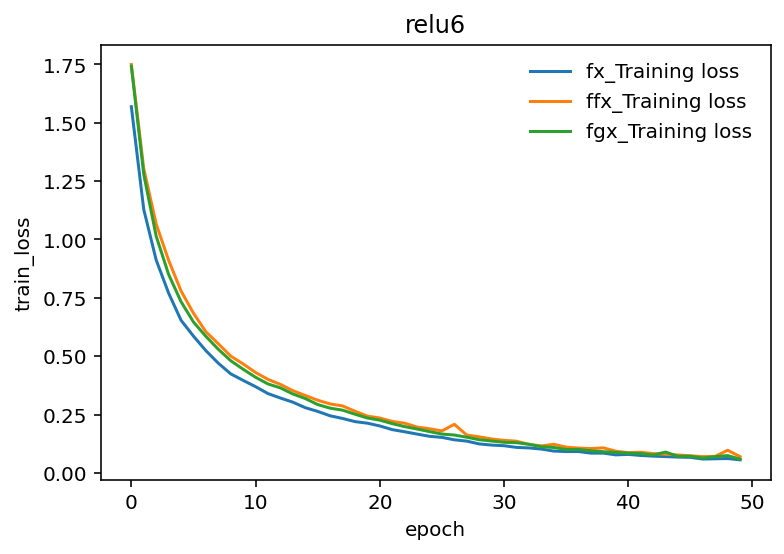

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


plt.title(experiment_name) # title
plt.ylabel("train_loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_train_losses, label='fx_Training loss')
plt.plot(ffx_train_losses, label='ffx_Training loss')
plt.plot(fgx_train_losses, label='fgx_Training loss')
plt.legend(frameon=False)

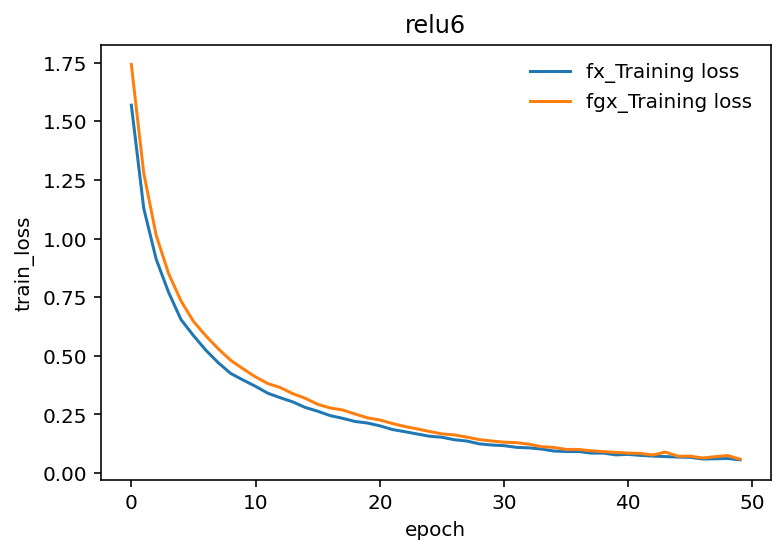

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


plt.title(experiment_name) # title
plt.ylabel("train_loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_train_losses, label='fx_Training loss')
plt.plot(fgx_train_losses, label='fgx_Training loss')
plt.legend(frameon=False)

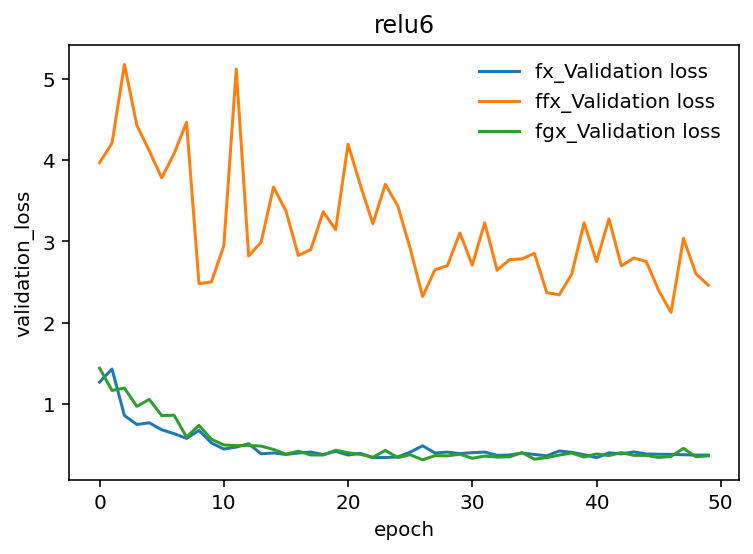

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.title(experiment_name) # title
plt.ylabel("validation_loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_valid_losses, label='fx_Validation loss')
plt.plot(ffx_valid_losses, label='ffx_Validation loss')
plt.plot(fgx_valid_losses, label='fgx_Validation loss')
plt.legend(frameon=False)

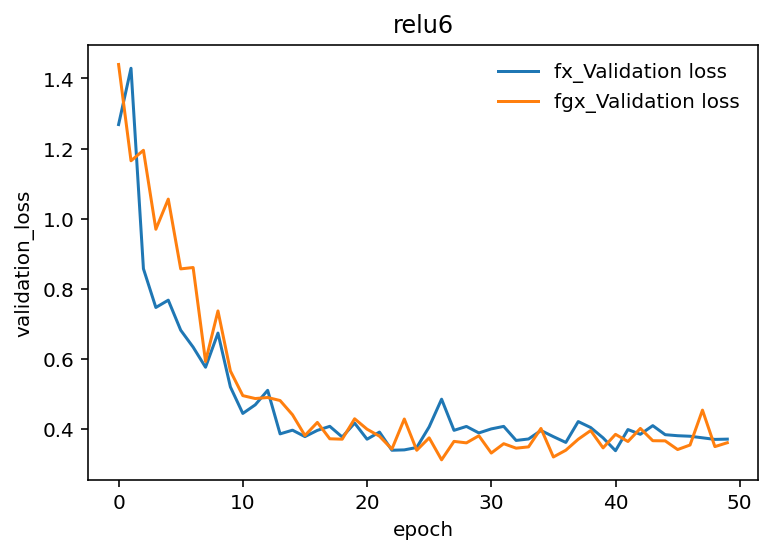

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.title(experiment_name) # title
plt.ylabel("validation_loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_valid_losses, label='fx_Validation loss')
plt.plot(fgx_valid_losses, label='fgx_Validation loss')
plt.legend(frameon=False)

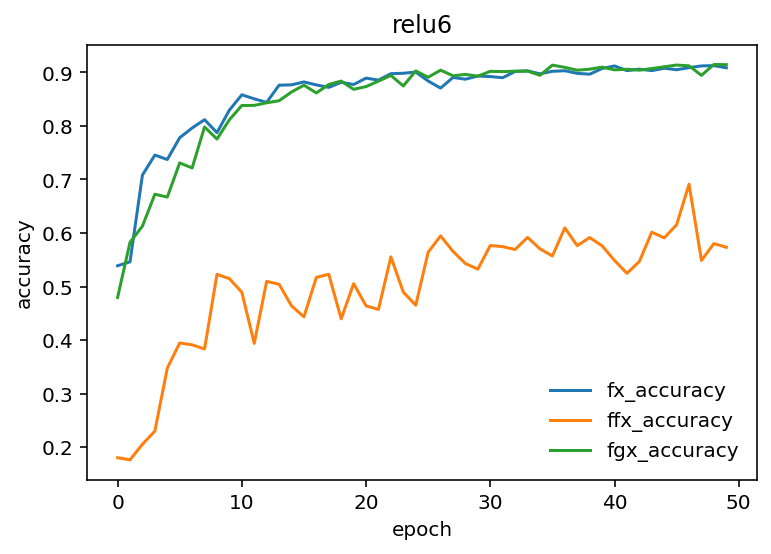

In [23]:
plt.title(experiment_name) # title
plt.ylabel("accuracy") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_accuracies, label='fx_accuracy')
plt.plot(ffx_accuracies, label='ffx_accuracy')
plt.plot(fgx_accuracies, label='fgx_accuracy')
plt.legend(frameon=False)

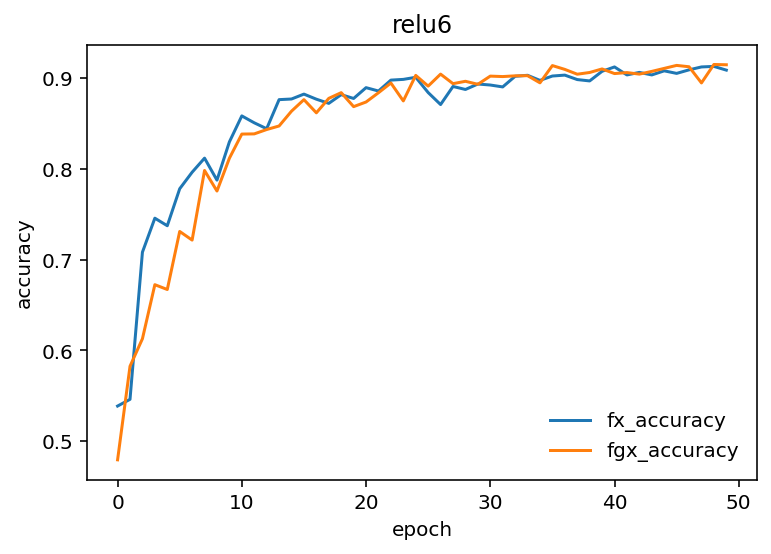

In [24]:
plt.title(experiment_name) # title
plt.ylabel("accuracy") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_accuracies, label='fx_accuracy')
plt.plot(fgx_accuracies, label='fgx_accuracy')
plt.legend(frameon=False)

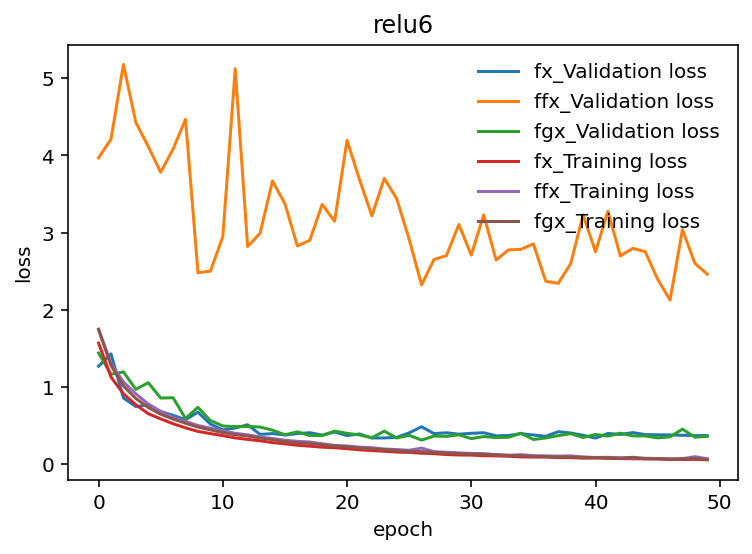

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.title(experiment_name) # title
plt.ylabel("loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_valid_losses, label='fx_Validation loss')
plt.plot(ffx_valid_losses, label='ffx_Validation loss')
plt.plot(fgx_valid_losses, label='fgx_Validation loss')
plt.plot(fx_train_losses, label='fx_Training loss')
plt.plot(ffx_train_losses, label='ffx_Training loss')
plt.plot(fgx_train_losses, label='fgx_Training loss')
plt.legend(frameon=False)

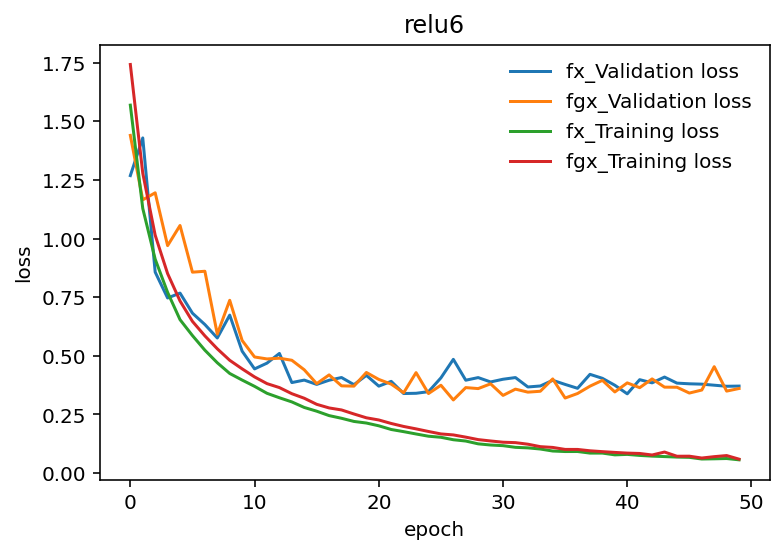

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.title(experiment_name) # title
plt.ylabel("loss") # y label
plt.xlabel("epoch") # x label
plt.plot(fx_valid_losses, label='fx_Validation loss')
plt.plot(fgx_valid_losses, label='fgx_Validation loss')
plt.plot(fx_train_losses, label='fx_Training loss')
plt.plot(fgx_train_losses, label='fgx_Training loss')
plt.legend(frameon=False)